In [2]:
from astropy.io import fits as pyfits, ascii as asc
from astropy.table import Table
from create_ordered_AP_arrays import create_ordered_AP_arrays
import numpy as np, matplotlib.pyplot as plt
import plotting.general_plotting as general_plotting
import plotting_NII_Ha_ratios

from analysis.cardelli import *
from astropy.cosmology import FlatLambdaCDM
from scipy import stats
from scipy.interpolate import interp1d
cosmo = FlatLambdaCDM(H0 = 70 * u.km / u.s / u.Mpc, Om0=0.3)


FULL_PATH = '/Users/kaitlynshin/GoogleDrive/NASA_Summer2015/'

In [3]:
import create_ordered_AP_arrays
reload(create_ordered_AP_arrays)
from create_ordered_AP_arrays import create_ordered_AP_arrays

## EBV_corrections.py

In [4]:
def apply_filt_corrs_interp(ff, filt_corrs, zspec0, bad_z, good_z, AP, allcolsdata):
    '''
    Applies the filter-based correction.

    Accepts only no/yes_spectra sources with filter matches.

    For the sources with no_spectra (bad_z), a statistical correction based on
    the filter response profile was provided.
    For the ones with a yes_spectra (good_z), the relevant filter response .dat file
    was read in and interpolated to try and find what kind of flux a source 
    with that zspec would have in the filter response. the flux filter correction
    factor was returned.

    (filt_corrs = filter_corrected_fluxes - orig_NB_flux_from_allcolsdata)
    '''
    print ff, len(bad_z)+len(good_z)
    # reading data
    response = asc.read(FULL_PATH+'Filters/'+ff+'response.dat',guess=False,
                    Reader=asc.NoHeader)
    z_filt = response['col1'].data/6562.8 - 1
    yresponse = np.array(response['col2'])

    filter_stat_corr_dict = {'NB704':1.289439104, 'NB711':1.41022358406, 'NB816':1.29344789854, 'NB921':1.32817034288, 'NB973':1.29673596942}
    filt_corrs[bad_z] = np.log10(filter_stat_corr_dict[ff]) # np.log10(1.28)
    
    f = interp1d(z_filt, response['col2'])

    if max(zspec0[good_z]) > max(z_filt):
        print 'Source above filter profile range (', ff, '|| z =', max(zspec0[good_z]), ')'
        bad_z0 = np.array([x for x in good_z if zspec0[x] == max(zspec0[good_z])])
        DEIMOS = pyfits.open('/Users/kaitlynshin/GoogleDrive/NASA_Summer2015/Main_Sequence/Catalogs/Keck/DEIMOS_single_line_fit.fits')
        DEIMOSdata = DEIMOS[1].data
        print 'Source name:', AP[bad_z0]
        ii = np.where(DEIMOSdata['AP']==AP[bad_z0])[0]
        keck_flux = np.log10(DEIMOSdata['HA_FLUX_MOD'][ii])
        filtcorr_bflux = np.log10(10**keck_flux + 0.8e-17*1.33)
        print '>>>>>>> Filter-corrected excess flux:', filtcorr_bflux
        jj = np.where(zspec0==max(zspec0[good_z]))[0]
        filt_corrs[bad_z0] = filtcorr_bflux - allcolsdata[ff+'_FLUX'][jj]

        good_z = np.array([x for x in good_z if zspec0[x] != max(zspec0[good_z])])

        DEIMOS.close()

    filt_corrs[good_z] = np.log10(1.0/(f(zspec0[good_z])/max(yresponse)))

    # these are the filter correction factors
    return filt_corrs


def consolidate_ns_ys(orig_fluxes, no_spectra, yes_spectra, data_ns, data_ys, datatype='num'):
    '''
    consolidates no_spectra and yes_spectra data into a single data_array
    of shape orig_fluxes (same as allcolsdata)
    '''
    consod = np.zeros(len(orig_fluxes))
    if datatype == 'str':
        consod = np.array(['']*len(orig_fluxes), dtype='|S10')

    consod[no_spectra] = data_ns
    consod[yes_spectra] = data_ys

    return consod


def get_bins(masslist_MMT, masslist_Keck, massZlist_MMT, massZlist_Keck):
    '''
    Helper function for main. Flattens ndarrays of bins into a bins array

    Doesn't include the max_mass as an upper bound to the mass bins so that
    sources that have m > m_max_bin will automatically fall into the highest
    bin.
    Ex:
      >>> x = np.array([5.81, 6.78, 7.12, 7.94, 9.31])
      >>> bins = np.array([6.2, 7.53, 9.31]) 
      >>> np.digitize(x, bins, right=True)
      array([0, 1, 1, 2, 2]) # instead of array([0, 1, 1, 2, 3])
    '''
    massbins_MMT = np.append(masslist_MMT[:,0], masslist_MMT[-1,-1])
    massbins_Keck = np.append(masslist_Keck[:,0], masslist_Keck[-1,-1])
    massZbins_MMT = np.append(massZlist_MMT[:,0], massZlist_MMT[-1,-1])
    massZbins_Keck = np.append(massZlist_Keck[:,0], massZlist_Keck[-1,-1])

    return massbins_MMT, massbins_Keck, massZbins_MMT, massZbins_Keck


def fix_masses_out_of_range(masses_MMT_ii, masses_Keck_ii, masstype):
    '''
    Fixes masses that were not put into bins because they were too low.
    Reassigns them to the lowest mass bin. 

    Does this for both stlrmass bins and stlrmassZ bins.
    '''
    if masstype=='stlrmass':
        masses_MMT_ii = np.array([1 if x==0 else x for x in masses_MMT_ii])
        masses_Keck_ii = np.array([1 if x==0 else x for x in masses_Keck_ii])
    else: #=='stlrmassZ'
        masses_MMT_ii = np.array(['1'+x[1:] if x[0]=='0' else x for x in masses_MMT_ii])
        masses_Keck_ii = np.array(['1'+x[1:] if x[0]=='0' else x for x in masses_Keck_ii])

    return masses_MMT_ii, masses_Keck_ii


def bins_table_no_spectra(indexes, NAME0, AP, stlr_mass, massbins_MMT, massbins_Keck, 
    massZbins_MMT, massZbins_Keck, massZlist_filts_MMT, massZlist_filts_Keck):
    '''
    Creates and returns a table of bins as such:

    NAME             stlrmass filter stlrmassbin_MMT stlrmassbin_Keck stlrmassZbin_MMT stlrmassZbin_Keck
    ---------------- -------- ------ --------------- ---------------- ---------------- -----------------
    Ha-NB973_178201  8.4      NB973  4               3                2-NB973          2-NB973

    WARNINGS: 
    - dual Ha-NB704/Ha-NB711 sources are being treated as Ha-NB704 sources for now, but
      we may have to use photometry to better determine which EBV values to use
    - Ha-NB704+OII-NB973 sources are being treated as Ha-NB704 sources for now, but 
      they may be excluded as they may be something else given the NB973 excess
    '''
    names = NAME0[indexes]
    masses = stlr_mass[indexes]

    # get redshift bins
    filts = np.array([x[x.find('Ha-')+3:x.find('Ha-')+8] for x in names])
    
    # this ensures that NB704+NB921 dual emitters will be placed in Ha-NB921 bins
    #  since these sources are likely OIII-NB704 and Ha-NB921
    dual_iis = [x for x in range(len(names)) if 'Ha-NB704' in names[x] and 'Ha-NB921' in names[x]]
    filts[dual_iis] = 'NB921'
    
    # this ensures that the NB816+NB921 dual emitter will be placed in the NB921 bin
    #  we decided this based on visual inspection of the photometry
    dual_ii2 = [x for x in range(len(names)) if 'Ha-NB816' in names[x] and 'Ha-NB921' in names[x]]
    filts[dual_ii2] = 'NB921'

    # get stlrmass bins
    masses_MMT_ii = np.digitize(masses, massbins_MMT, right=True)
    masses_Keck_ii = np.digitize(masses, massbins_Keck, right=True)
    masses_MMT, masses_Keck = fix_masses_out_of_range(masses_MMT_ii, masses_Keck_ii, 'stlrmass')
    
    # get stlrmassZ bins
    ii0 = 0
    ii1 = 0
    massZs_MMT = np.array(['UNFILLED']*len(indexes))
    massZs_Keck = np.array(['UNFILLED']*len(indexes))
    for ff in ['NB704','NB711','NB816','NB921','NB973']:
        jj = len(np.where(ff==massZlist_filts_MMT)[0])        
        
        good_filt_iis = np.array([x for x in range(len(filts)) if filts[x]==ff])
        
        if ff=='NB973':
            jj += 1
        
        mass_MMT_iis  = np.digitize(masses[good_filt_iis], massZbins_MMT[ii0:ii0+jj], right=True)
        massZ_MMT_iis = np.array([str(x)+'-'+ff for x in mass_MMT_iis])
        massZs_MMT[good_filt_iis] = massZ_MMT_iis
        
        ii0+=jj
        if 'NB9' in ff:
            kk = len(np.where(ff==massZlist_filts_Keck)[0])

            if ff=='NB973':
                kk += 1
                
            mass_Keck_iis  = np.digitize(masses[good_filt_iis], massZbins_Keck[ii1:ii1+kk], right=True)
            massZ_Keck_iis = np.array([str(x)+'-'+ff for x in mass_Keck_iis])
            massZs_Keck[good_filt_iis] = massZ_Keck_iis
            
            ii1+=kk
        else:
            massZs_Keck[good_filt_iis] = np.array(['N/A']*len(good_filt_iis))
            masses_Keck[good_filt_iis] = -99
    
    # putting sources with m < m_min_bin in the lowest-massZ mass bin
    massZs_MMT, massZs_Keck = fix_masses_out_of_range(massZs_MMT, massZs_Keck, 'stlrmassZ')

        
    tab0 = Table([names, masses, filts, masses_MMT, masses_Keck, massZs_MMT, massZs_Keck], 
        names=['NAME', 'stlrmass', 'filter', 'stlrmassbin_MMT', 'stlrmassbin_Keck', 
               'stlrmassZbin_MMT', 'stlrmassZbin_Keck'])

    return tab0


def EBV_corrs_no_spectra(tab_no_spectra, mmt_mz, mmt_mz_EBV_hahb, mmt_mz_EBV_hghb, keck_mz, keck_mz_EBV_hahb):
    '''
    '''
    EBV_corrs = np.array([-100.0]*len(tab_no_spectra))

    # loop based on filter
    for ff in ['NB704', 'NB711', 'NB816', 'NB921', 'NB973']:
        bin_filt_iis = np.array([x for x in range(len(tab_no_spectra)) if tab_no_spectra['filter'][x]==ff])
        print 'num in '+ff+':', len(bin_filt_iis)

        if ff=='NB704' or ff=='NB711' or ff=='NB816':
            tab_filt_iis = np.array([x for x in range(len(mmt_mz)) if 
                (mmt_mz['filter'][x]==ff and mmt_mz['stlrmass_bin'][x] != 'N/A')])
            m_bin = np.array([int(x[0])-1 for x in tab_no_spectra['stlrmassZbin_MMT'][bin_filt_iis]])

            for ii, m_i in enumerate(m_bin):
                EBV_corrs[bin_filt_iis[ii]] = mmt_mz_EBV_hahb[tab_filt_iis[m_i]]

        elif ff == 'NB921':
            # for sources that fall within the keck mass range
            bin_filt_iis_keck = np.array([x for x in range(len(tab_no_spectra)) if 
                (tab_no_spectra['filter'][x]==ff and tab_no_spectra['stlrmass'][x]<=9.78)])
            tab_filt_iis_keck = np.array([x for x in range(len(keck_mz)) if 
                (keck_mz['filter'][x]==ff and keck_mz['stlrmass_bin'][x] != 'N/A')])
            m_bin_keck = np.array([int(x[0])-1 for x in tab_no_spectra['stlrmassZbin_Keck'][bin_filt_iis_keck]])

            for ii, m_i in enumerate(m_bin_keck):
                EBV_corrs[bin_filt_iis_keck[ii]] = keck_mz_EBV_hahb[tab_filt_iis_keck[m_i]]

            # for sources that fall above the keck mass range (so we use mmt)
            bin_filt_iis_mmt = np.array([x for x in range(len(tab_no_spectra)) if 
                (tab_no_spectra['filter'][x]==ff and tab_no_spectra['stlrmass'][x]>9.78)])
            tab_filt_iis_mmt = np.array([x for x in range(len(mmt_mz)) if 
                (mmt_mz['filter'][x]==ff and mmt_mz['stlrmass_bin'][x] != 'N/A')])
            m_bin_mmt = np.array([int(x[0])-1 for x in tab_no_spectra['stlrmassZbin_MMT'][bin_filt_iis_mmt]])

            for ii, m_i in enumerate(m_bin_mmt):
                EBV_corrs[bin_filt_iis_mmt[ii]] = mmt_mz_EBV_hghb[tab_filt_iis_mmt[m_i]]
            
        elif ff == 'NB973':
            tab_filt_iis = np.array([x for x in range(len(keck_mz)) if 
                (keck_mz['filter'][x]==ff and keck_mz['stlrmass_bin'][x] != 'N/A')])
            m_bin = np.array([int(x[0])-1 for x in tab_no_spectra['stlrmassZbin_Keck'][bin_filt_iis]])

            for ii, m_i in enumerate(m_bin):
                EBV_corrs[bin_filt_iis[ii]] = keck_mz_EBV_hahb[tab_filt_iis[m_i]]
    #endfor

    assert len([x for x in EBV_corrs if x==-100.0]) == 0
    return EBV_corrs


In [5]:
# reading in data
nbia = pyfits.open(FULL_PATH+'Catalogs/NB_IA_emitters.nodup.colorrev.fix.fits')
nbiadata = nbia[1].data
allcols = pyfits.open(FULL_PATH+'Catalogs/NB_IA_emitters.allcols.colorrev.fits')
allcolsdata0 = allcols[1].data
NAME0 = np.array(nbiadata['NAME'])
ID0   = np.array(nbiadata['ID'])
zspec = asc.read(FULL_PATH+'Catalogs/nb_ia_zspec.txt',guess=False,
                 Reader=asc.CommentedHeader)
zspec0 = np.array(zspec['zspec0'])
inst_str0 = np.array(zspec['inst_str0'])
fout  = asc.read(FULL_PATH+'FAST/outputs/NB_IA_emitters_allphot.emagcorr.ACpsf_fast.fout',
                 guess=False,Reader=asc.NoHeader)
stlr_mass = np.array(fout['col7'])
data_dict = create_ordered_AP_arrays()
AP = data_dict['AP']
HA_FLUX   = data_dict['HA_FLUX']
HB_FLUX   = data_dict['HB_FLUX']
HB_SNR    = data_dict['HB_SNR']
NIIB_FLUX = data_dict['NIIB_FLUX']
NIIB_SNR  = data_dict['NIIB_SNR']
NIIB_Ha_ratios = asc.read(FULL_PATH+'Main_Sequence/Catalogs/line_emission_ratios_table.dat',
    guess=False,Reader=asc.CommentedHeader)
ratio0 = np.array(NIIB_Ha_ratios['NII_Ha_ratio'])
ratio1 = np.array(NIIB_Ha_ratios['OIIIR_HB_ratio'])
coverage = np.array(NIIB_Ha_ratios['POOR_NIIB_COVERAGE'])


# defining other useful data structs
filtarr = np.array(['NB704', 'NB711', 'NB816', 'NB921', 'NB973'])
inst_dict = {}
inst_dict['MMT']  = ['MMT,FOCAS,','MMT,','merged,','MMT,Keck,']
inst_dict['Keck'] = ['merged,','Keck,','Keck,Keck,','Keck,FOCAS,','Keck,FOCAS,FOCAS,','Keck,Keck,FOCAS,']


# limit all data to Halpha emitters only
ha_ii = np.array([x for x in range(len(NAME0)) if 'Ha-NB' in NAME0[x]])
NAME0       = NAME0[ha_ii]

# getting rid of special cases (no_spectra):
bad_highz_gal = np.where(NAME0=='Ha-NB816_174829_Ha-NB921_187439_Lya-IA598_163379')[0]

bad_HbNB704_SIINB973_gals = np.array([x for x in range(len(ha_ii)) if 
    (NAME0[x]=='Ha-NB704_028405_OII-NB973_056979' or 
        NAME0[x]=='Ha-NB704_090945_OII-NB973_116533')])

# getting rid of a source w/o flux (yes_spectra):
no_flux_gal = np.where(NAME0=='Ha-NB921_069950')[0]

# getting rid of a source w/ atypical SFR behavior we don't understand
weird_SFR_gal = np.where(NAME0=='OIII-NB704_063543_Ha-NB816_086540')[0]

bad_sources = np.concatenate([bad_highz_gal, bad_HbNB704_SIINB973_gals, no_flux_gal, weird_SFR_gal])
ha_ii = np.delete(ha_ii, bad_sources)
NAME0 = np.delete(NAME0, bad_sources)

ID0         = ID0[ha_ii]
zspec0      = zspec0[ha_ii]
inst_str0   = inst_str0[ha_ii]
stlr_mass   = stlr_mass[ha_ii]
AP          = AP[ha_ii]
HA_FLUX     = HA_FLUX[ha_ii]
HB_FLUX     = HB_FLUX[ha_ii]
HB_SNR      = HB_SNR[ha_ii]
NIIB_FLUX   = NIIB_FLUX[ha_ii]
NIIB_SNR    = NIIB_SNR[ha_ii]
allcolsdata = allcolsdata0[ha_ii]
ratio0 = ratio0[ha_ii]
ratio1 = ratio1[ha_ii]
coverage = coverage[ha_ii]

no_spectra  = np.where((zspec0 <= 0) | (zspec0 > 9))[0]
yes_spectra = np.where((zspec0 >= 0) & (zspec0 < 9))[0]


# reading in EBV data tables & getting relevant EBV cols
mmt_z   = asc.read(FULL_PATH+'Composite_Spectra/Redshift/MMT_stacked_spectra_data.txt')
mmt_z_EBV_hahb = np.array(mmt_z['E(B-V)_hahb'])
mmt_z_EBV_hghb = np.array(mmt_z['E(B-V)_hghb'])

keck_z  = asc.read(FULL_PATH+'Composite_Spectra/Redshift/Keck_stacked_spectra_data.txt')
keck_z_EBV_hahb = np.array(keck_z['E(B-V)_hahb'])

mmt_m   = asc.read(FULL_PATH+'Composite_Spectra/StellarMass/MMT_all_five_data.txt')
mmt_m_EBV_hahb = np.array(mmt_m['E(B-V)_hahb'])
mmt_m_EBV_hghb = np.array(mmt_m['E(B-V)_hghb'])

keck_m  = asc.read(FULL_PATH+'Composite_Spectra/StellarMass/Keck_all_five_data.txt')
keck_m_EBV_hahb = np.array(keck_m['E(B-V)_hahb'])

mmt_mz  = asc.read(FULL_PATH+'Composite_Spectra/StellarMassZ/MMT_stlrmassZ_data.txt')
mmt_mz_EBV_hahb = np.array(mmt_mz['E(B-V)_hahb'])
mmt_mz_EBV_hghb = np.array(mmt_mz['E(B-V)_hghb'])

keck_mz = asc.read(FULL_PATH+'Composite_Spectra/StellarMassZ/Keck_stlrmassZ_data.txt')
keck_mz_EBV_hahb = np.array(keck_mz['E(B-V)_hahb'])


# mass 'bin' lists made by reading in from files generated by the stack plots
masslist_MMT  = np.array([x.split('-') for x in mmt_m['stlrmass_bin']], dtype=float) 
masslist_Keck = np.array([x.split('-') for x in keck_m['stlrmass_bin']], dtype=float)

# same with massZ 'bin' lists (also getting the filts)
massZlist_MMT  = np.array([x.split('-') for x in mmt_mz['stlrmass_bin'] if x!='N/A'], dtype=float)
massZlist_Keck = np.array([x.split('-') for x in keck_mz['stlrmass_bin']], dtype=float)
massZlist_filts_MMT  = np.array([mmt_mz['filter'][x] for x in range(len(mmt_mz)) if mmt_mz['stlrmass_bin'][x]!='N/A'])
massZlist_filts_Keck = np.array([keck_mz['filter'][x] for x in range(len(keck_mz))])

# splitting the 'bin' lists from above into a flattened bins array
massbins_MMT, massbins_Keck, massZbins_MMT, massZbins_Keck = get_bins(masslist_MMT, 
    masslist_Keck, massZlist_MMT, massZlist_Keck)

# getting tables of which bins the sources fall into (for eventual EBV corrections)
tab_no_spectra = bins_table_no_spectra(no_spectra, NAME0, AP, stlr_mass, 
    massbins_MMT, massbins_Keck, massZbins_MMT, massZbins_Keck, massZlist_filts_MMT, massZlist_filts_Keck)
tab_yes_spectra = bins_table_no_spectra(yes_spectra, NAME0, AP, stlr_mass, 
    massbins_MMT, massbins_Keck, massZbins_MMT, massZbins_Keck, massZlist_filts_MMT, massZlist_filts_Keck)
FILT = consolidate_ns_ys(allcolsdata, no_spectra, yes_spectra,
    np.array(tab_no_spectra['filter']), np.array(tab_yes_spectra['filter']), datatype='str')


print '### obtaining filter corrections'
#   TODO: correct nb704/nb711 dual emitters for both?
orig_fluxes = np.zeros(len(allcolsdata))
filt_corr_factor = np.zeros(len(allcolsdata))
for filt in filtarr:
    filt_ii = np.array([x for x in range(len(FILT)) if filt==FILT[x]])

    no_spectra_temp  = np.array([x for x in filt_ii if x in no_spectra])
    yes_spectra_temp = np.array([x for x in filt_ii if x in yes_spectra])

    orig_fluxes[filt_ii] = allcolsdata[filt+'_FLUX'][filt_ii]
    filt_corr_factor = apply_filt_corrs_interp(filt, filt_corr_factor, zspec0, 
        no_spectra_temp, yes_spectra_temp, AP, allcolsdata)
#endfor


print '### obtaining nii_ha corrections'
linedict = plotting_NII_Ha_ratios.main()
C = linedict['C']
b = linedict['b']
m = linedict['m']

nii_ha_ratio = np.zeros(len(allcolsdata))
ratio_vs_line = np.array(['']*len(allcolsdata), dtype='|S5')

# NIIB_SNR >= 2
highSNR = np.array([x for x in range(len(NIIB_SNR)) 
    if (NIIB_SNR[x] >= 2 and NIIB_FLUX[x] != 0 and HA_FLUX[x] < 99)])
nii_ha_ratio[highSNR] = 1.33*NIIB_FLUX[highSNR]/HA_FLUX[highSNR]
ratio_vs_line[highSNR] = 'ratio'

# NIIB_SNR < 2
lowSNR = np.array([x for x in range(len(NIIB_SNR)) if x not in highSNR])
ratio_vs_line[lowSNR] = 'line'
llow_m  = np.array([x for x in range(len(lowSNR)) if stlr_mass[lowSNR][x] <= 8])
lhigh_m = np.array([x for x in range(len(lowSNR)) if stlr_mass[lowSNR][x] > 8])
nii_ha_ratio[lowSNR[llow_m]] = C
nii_ha_ratio[lowSNR[lhigh_m]] = m*(stlr_mass[lowSNR[lhigh_m]])+b

nii_ha_corr_factor = np.log10(1/(1+nii_ha_ratio))

### done reading input files
### creating ordered AP arr
### done creating ordered AP arr
### creating ordered LMIN0/LMAX0 arrs
### done creating ordered LMIN0/LMAX0 arr
### creating ordered SNR arrs
### done creating ordered SNR arrs
### creating ordered FLUX arrs
### done creating ordered FLUX arrs
### obtaining filter corrections
NB704 134
NB711 101
NB816 218
NB921 391
Source above filter profile range ( NB921 || z = 0.4282 )
Source name: ['36.090']
>>>>>>> Filter-corrected excess flux: [-16.15316345]
NB973 236
### obtaining nii_ha corrections
### done reading input files
### creating ordered AP arr
### done creating ordered AP arr
### creating ordered LMIN0/LMAX0 arrs
### done creating ordered LMIN0/LMAX0 arr
### creating ordered SNR arrs
### done creating ordered SNR arrs
### creating ordered FLUX arrs
### done creating ordered FLUX arrs
C = 0.05378263129
m = 0.169053785015 & b = -1.29864764883


## doing EBV_corrs_yes_spectra now?

In [6]:
tab_yes_spectra

NAME,stlrmass,filter,stlrmassbin_MMT,stlrmassbin_Keck,stlrmassZbin_MMT,stlrmassZbin_Keck
str67,float64,str5,int64,int64,str7,str7
Ha-NB704_001870,7.73,NB704,1,-99,2-NB704,N/A
Ha-NB704_005232,6.71,NB704,1,-99,1-NB704,N/A
OIII-NB704_006046_Ha-NB921_020459,7.81,NB921,2,1,1-NB921,1-NB921
OIII-NB704_006189_Ha-NB921_021464,8.2,NB921,3,2,2-NB921,3-NB921
OIII-NB704_007013_Ha-NB921_021654,7.84,NB921,2,1,1-NB921,1-NB921
OIII-NB704_008072_Ha-NB921_024022,9.09,NB921,5,4,5-NB921,5-NB921
OIII-NB704_008531_Ha-NB921_023840,8.45,NB921,3,3,4-NB921,3-NB921
OIII-NB704_009828_Ha-NB921_025142,8.56,NB921,4,3,4-NB921,4-NB921
Ha-NB704_009999,7.3,NB704,1,-99,1-NB704,N/A


In [10]:
len(yes_spectra)

373

In [11]:
gg = np.where(HB_SNR[yes_spectra] >= 5)[0]
len(gg)

243

In [12]:
print len(np.where(HA_FLUX[yes_spectra][gg] == -1)[0])
print len(np.where(HA_FLUX[yes_spectra][gg] == 0)[0])
print len(np.where(HA_FLUX[yes_spectra][gg] > 99)[0])

ggg = np.where((HB_SNR[yes_spectra] >= 5) & (HA_FLUX[yes_spectra] > 1e-20) & (HA_FLUX[yes_spectra] < 99))[0]
len(ggg)

33
13
31


162

In [13]:
good_EBV_iis = yes_spectra[ggg]

hahb = HA_FLUX[good_EBV_iis]/HB_FLUX[good_EBV_iis]
hahb = np.array([2.86 if (x < 2.86 and x > 0) else x for x in hahb])

In [14]:
k_hb = cardelli(4861 * u.Angstrom)
k_ha = cardelli(6563 * u.Angstrom)

EBV_hahb = np.log10((hahb)/2.86)/(-0.4*(k_ha - k_hb))

In [15]:
EBV_hahb

array([ 0.65952345,  0.15730329,  0.70797507,  0.07928244,  0.37595703,
        0.46047257,  0.0745491 ,  0.        ,  0.        ,  0.00588278,
        0.        ,  0.        ,  0.28847019,  0.        ,  0.23075396,
        0.10610641,  0.16722952,  0.        ,  0.43095863,  0.39080689,
        0.09208775,  0.35016038,  0.16487851,  0.        ,  0.3691403 ,
        0.22659265,  0.25753989,  0.13000359,  0.2677368 ,  0.33048688,
        0.3798872 ,  0.24944559,  0.288873  ,  0.        ,  0.        ,
        0.03465158,  0.06264799,  0.08152886,  0.65655054,  0.25101432,
        0.        ,  0.05770491,  0.1264168 ,  0.        ,  0.04598953,
        0.        ,  0.        ,  0.        ,  0.63332573,  0.        ,
        0.        ,  0.1225152 ,  0.        ,  0.02691998,  0.        ,
        0.39110383,  0.08498065,  0.2499764 ,  0.        ,  0.        ,
        0.01983627,  0.25924524,  0.        ,  0.        ,  0.45629928,
        0.25295667,  0.        ,  0.18786674,  0.24849348,  0.  

In [16]:
len(EBV_hahb)

162

In [17]:
len(good_EBV_iis)

162

In [18]:
EBV_corrs_ys[ggg] = EBV_hahb

NameError: name 'EBV_corrs_ys' is not defined

In [19]:
test = EBV_corrs_ys
testt = EBV_corrs_ys[ggg]

NameError: name 'EBV_corrs_ys' is not defined

In [20]:
NAME0[good_EBV_iis]

array(['Ha-NB704_001870', 'Ha-NB704_005232',
       'OIII-NB704_008072_Ha-NB921_024022', 'Ha-NB704_009999',
       'OIII-NB704_014219_Ha-NB921_031375',
       'OIII-NB704_014628_Ha-NB921_032409', 'Ha-NB704_018318',
       'OIII-NB704_018917_Ha-NB921_039277',
       'OIII-NB704_022975_Ha-NB921_045096',
       'OIII-NB704_023151_Ha-NB921_045274',
       'OIII-NB704_026198_Ha-NB921_050258',
       'OIII-NB704_036405_Ha-NB921_063205',
       'Ha-NB704_036535_Ha-NB711_030935',
       'Ha-NB704_038884_Ha-NB711_032808',
       'OIII-NB704_045053_Ha-NB921_074096',
       'OIII-NB704_045386_Ha-NB921_074253', 'Ha-NB704_045509',
       'Ha-NB704_046420', 'Ha-NB704_046635',
       'OIII-NB704_047277_Ha-NB921_076691',
       'OIII-NB704_047852_Ha-NB921_077288',
       'OIII-NB704_049237_Ha-NB921_078221',
       'OIII-NB704_049936_Ha-NB921_079428_OIII-IA679_062450',
       'OIII-NB704_050874_Ha-NB921_080954',
       'OIII-NB704_051994_Ha-NB921_082395',
       'OIII-NB704_053974_Ha-NB921_084866',
   

In [21]:
len(ggg)

162

In [22]:
def EBV_corrs_yes_spectra(EBV_corrs_ys, yes_spectra, HA_FLUX, HB_FLUX, HB_SNR):
    '''
    '''
    k_hb = cardelli(4861 * u.Angstrom)
    k_ha = cardelli(6563 * u.Angstrom)
    
    gooddata_iis = np.where((HB_SNR[yes_spectra] >= 5) & (HA_FLUX[yes_spectra] > 1e-20) & (HA_FLUX[yes_spectra] < 99))[0]
    good_EBV_iis = yes_spectra[gooddata_iis]

    hahb = HA_FLUX[good_EBV_iis]/HB_FLUX[good_EBV_iis]
    hahb = np.array([2.86 if (x < 2.86 and x > 0) else x for x in hahb])
    EBV_hahb = np.log10((hahb)/2.86)/(-0.4*(k_ha - k_hb))
    
    EBV_corrs_ys[gooddata_iis] = EBV_hahb
    
    return EBV_corrs_ys

In [23]:
len([x for x in range(len(EBV_hahb)) if EBV_hahb[x]!=0 and EBV_corrs_ys[ggg][x] == 0])

NameError: name 'EBV_corrs_ys' is not defined

In [24]:
EBV_corrs_ys = EBV_corrs_no_spectra(tab_yes_spectra, mmt_mz, mmt_mz_EBV_hahb, 
        mmt_mz_EBV_hghb, keck_mz, keck_mz_EBV_hahb)

EBV_corrs_ys = EBV_corrs_yes_spectra(EBV_corrs_ys, yes_spectra, HA_FLUX, HB_FLUX, HB_SNR)

num in NB704: 21
num in NB711: 3
num in NB816: 50
num in NB921: 208
num in NB973: 91


In [25]:
EBV_corrs_ys[ggg]

array([ 0.65952345,  0.15730329,  0.70797507,  0.07928244,  0.37595703,
        0.46047257,  0.0745491 ,  0.        ,  0.        ,  0.00588278,
        0.        ,  0.        ,  0.28847019,  0.        ,  0.23075396,
        0.10610641,  0.16722952,  0.        ,  0.43095863,  0.39080689,
        0.09208775,  0.35016038,  0.16487851,  0.        ,  0.3691403 ,
        0.22659265,  0.25753989,  0.13000359,  0.2677368 ,  0.33048688,
        0.3798872 ,  0.24944559,  0.288873  ,  0.        ,  0.        ,
        0.03465158,  0.06264799,  0.08152886,  0.65655054,  0.25101432,
        0.        ,  0.05770491,  0.1264168 ,  0.        ,  0.04598953,
        0.        ,  0.        ,  0.        ,  0.63332573,  0.        ,
        0.        ,  0.1225152 ,  0.        ,  0.02691998,  0.        ,
        0.39110383,  0.08498065,  0.2499764 ,  0.        ,  0.        ,
        0.01983627,  0.25924524,  0.        ,  0.        ,  0.45629928,
        0.25295667,  0.        ,  0.18786674,  0.24849348,  0.  

In [26]:
EBV_corrs_ys

array([ 0.65952345,  0.15730329,  0.11352465,  0.07422418,  0.11352465,
        0.70797507,  0.07422418,  0.00600849,  0.07928244,  0.11352465,
        0.00600849,  0.09364662,  0.00600849,  0.00600849,  0.37595703,
        0.11352465,  0.46047257,  0.07422418,  0.13998411,  0.11352465,
        0.11352465,  0.07422418,  0.0745491 ,  0.        ,  0.11352465,
        0.07285908,  0.11352465,  0.11352465,  0.        ,  0.00588278,
        0.07285908,  0.11352465,  0.13998411,  0.13998411,  0.        ,
        0.09364662,  0.13998411,  0.13998411,  0.00600849,  0.11352465,
        0.11352465,  0.13998411,  0.11352465,  0.07422418,  0.07422418,
        0.13998411,  0.        ,  0.28847019,  0.07422418,  0.        ,
        0.11352465,  0.23075396,  0.10610641,  0.13998411,  0.16722952,
        0.        ,  0.43095863,  0.39080689,  0.11352465,  0.11352465,
        0.09208775,  0.11352465,  0.11352465,  0.35016038,  0.11352465,
        0.16487851,  0.        ,  0.13998411,  0.3691403 ,  0.00

### plotting M* vs EBV?

In [27]:
corr_tbl = asc.read(FULL_PATH+'Main_Sequence/mainseq_corrections_tbl.txt',guess=False,
                    Reader=asc.FixedWidthTwoLine)

In [28]:
corr_tbl

ID,NAME0,filt,inst_str0,zspec0,stlr_mass,obs_fluxes,obs_lumin,obs_sfr,filt_corr_factor,nii_ha_corr_factor,NII_Ha_ratio,ratio_vs_line,A_V,EBV,dust_corr_factor
int64,str51,str5,str13,float64,float64,float64,float64,float64,float64,float64,float64,str5,float64,float64,float64
1,Ha-NB704_001870,NB704,"MMT,",0.0724,7.73,-16.0044364929,39.1026327827,-2.25501263109,0.00733734433817,-0.022751036145,0.05378263129,line,1.67190157193,0.659523449619,1.67190157193
4,Ha-NB704_005232,NB704,"MMT,",0.0682,6.71,-16.057264328,38.9953448837,-2.36230053011,0.120403121769,-0.022751036145,0.05378263129,line,0.398766143474,0.15730329282,0.398766143474
6,Ha-NB704_005332,NB704,N/A,-10.0,6.78,-17.1989383698,37.9234719142,-3.43417349957,0.110400836647,-0.022751036145,0.05378263129,line,0.184698824633,0.0728590773569,0.184698824633
13,Ha-NB704_005572_OIII-IA598_028451,NB704,N/A,-10.0,5.81,-16.6326637268,38.4897465572,-2.86789885662,0.110400836647,-0.022751036145,0.05378263129,line,0.184698824633,0.0728590773569,0.184698824633
24,Ha-NB704_005882,NB704,N/A,-10.0,7.12,-17.2085037231,37.9139065609,-3.44373885296,0.110400836647,-0.022751036145,0.05378263129,line,0.184698824633,0.0728590773569,0.184698824633
26,Ha-NB704_005932,NB704,N/A,-10.0,5.98,-17.2530765533,37.8693337307,-3.48831168316,0.110400836647,-0.022751036145,0.05378263129,line,0.184698824633,0.0728590773569,0.184698824633
30,OIII-NB704_006046_Ha-NB921_020459,NB921,"MMT,",0.3977,7.81,-17.1826019287,39.5631519254,-1.79449348842,0.0224733687212,-0.022751036145,0.05378263129,line,0.287786632896,0.113524645271,0.287786632896
42,OIII-NB704_006189_Ha-NB921_021464,NB921,"MMT,",0.401,8.2,-16.7791481018,39.9750763456,-1.38256906816,0.000147988853939,-0.0364665587568,0.087593388293,line,0.188159369721,0.0742241760398,0.188159369721
54,Ha-NB704_006587,NB704,N/A,-10.0,6.48,-17.1835479736,37.9388623104,-3.41878310345,0.110400836647,-0.022751036145,0.05378263129,line,0.184698824633,0.0728590773569,0.184698824633


In [29]:
ebv00 = np.array(corr_tbl['EBV'])
mstar00 = np.array(corr_tbl['stlr_mass'])

gg = np.where(ebv00 > 0)[0]

ebv01 = ebv00[gg]
mstar01 = mstar00[gg]
zspec01 = np.array(corr_tbl['zspec0'])[gg]

zz = np.array([x for x in range(len(zspec01)) if zspec01[x] > 0 and zspec01[x] < 9])

ebv02 = ebv01[zz]
mstar02 = mstar01[zz]
zspec02 = zspec01[zz]
filt02 = np.array(corr_tbl['filt'][gg][zz])

In [30]:
aa = np.where((corr_tbl['filt']=='NB704') & (corr_tbl['zspec0'] > 0) & (corr_tbl['zspec0'] < 9))
bb = np.where((corr_tbl['filt']=='NB711') & (corr_tbl['zspec0'] > 0) & (corr_tbl['zspec0'] < 9))
cc = np.where((corr_tbl['filt']=='NB816') & (corr_tbl['zspec0'] > 0) & (corr_tbl['zspec0'] < 9))
dd = np.where((corr_tbl['filt']=='NB921') & (corr_tbl['zspec0'] > 0) & (corr_tbl['zspec0'] < 9))
ee = np.where((corr_tbl['filt']=='NB973') & (corr_tbl['zspec0'] > 0) & (corr_tbl['zspec0'] < 9))

In [31]:
nb704 = np.where(filt02=='NB704')[0]
nb711 = np.where(filt02=='NB711')[0]
nb816 = np.where(filt02=='NB816')[0]
nb921 = np.where(filt02=='NB921')[0]
nb973 = np.where(filt02=='NB973')[0]

(-0.02, 1.4000000000000001)

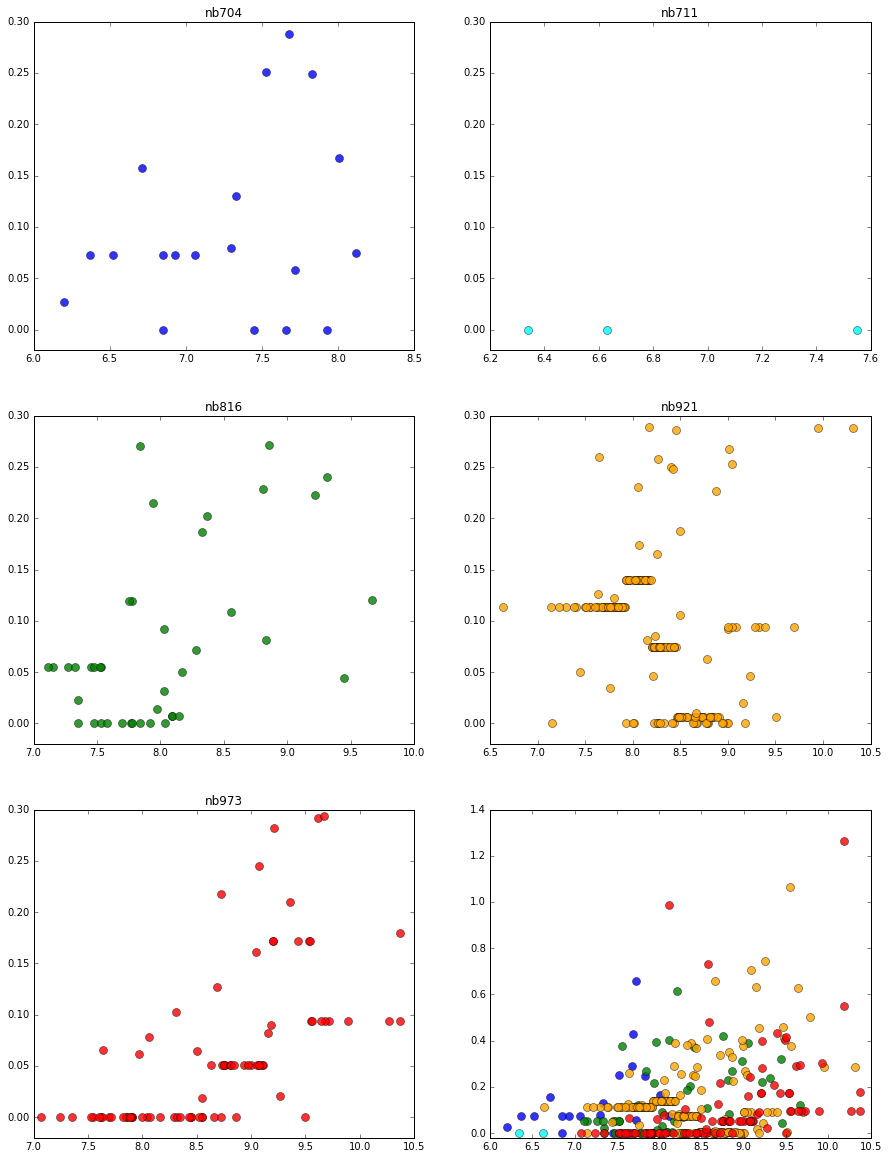

In [32]:
f, axes = plt.subplots(3,2)
f.set_size_inches(15,20)

axarr = np.ndarray.flatten(axes)

for ax, ii, lab, color in zip(axarr, [aa,bb,cc,dd,ee], 
                         ['nb704','nb711','nb816','nb921','nb973'], ['blue','cyan','green','orange','red']):
    ax.plot(mstar00[ii], ebv00[ii], color, marker='o', ls='None', label=lab, alpha=0.8, markersize=8)
    ax.set_ylim([-0.02, 0.3])
    ax.set_title(lab)
    
axarr[-1].plot(mstar00[aa], ebv00[aa], 'blue', marker='o', ls='None', label='nb704', alpha=0.8, markersize=8)
axarr[-1].plot(mstar00[bb], ebv00[bb], 'cyan', marker='o', ls='None', label='nb711', alpha=0.8, markersize=8)
axarr[-1].plot(mstar00[cc], ebv00[cc], 'green', marker='o', ls='None', label='nb816', alpha=0.8, markersize=8)
axarr[-1].plot(mstar00[dd], ebv00[dd], 'orange', marker='o', ls='None', label='nb921', alpha=0.8, markersize=8)
axarr[-1].plot(mstar00[ee], ebv00[ee], 'red', marker='o', ls='None', label='nb973', alpha=0.8, markersize=8)
axarr[-1].set_ylim(ymin=-0.02)

In [15]:
nbiadata.columns

ColDefs(
    name = 'ID'; format = 'J'; disp = 'I5'
    name = 'NAME'; format = '67A'
    name = 'RA'; format = 'D'; disp = 'F10.6'
    name = 'DEC'; format = 'D'; disp = 'F10.6'
    name = 'EXCESS'; format = 'E'; disp = 'F7.4'
    name = 'ZPHOT'; format = 'E'; disp = 'F7.4'
    name = 'MASS'; format = 'E'; disp = 'F7.3'
    name = 'LSFR'; format = 'E'; disp = 'F7.3'
    name = 'LSSFR'; format = 'E'; disp = 'F7.3'
    name = 'EW'; format = 'E'
    name = 'FLUX'; format = 'E'; disp = 'F7.4'
    name = 'NB'; format = 'E'; disp = 'F7.4'
)

In [16]:
# from scipy.optimize import curve_fit

# def line(x, m, b):
#     return m*x + b

# xarr = np.concatenate((stlr_mass[no_spectra], stlr_mass[yes_spectra]))
# yarr = np.concatenate((dustcorr_sfrs_ns, dustcorr_sfrs_ys))

# coeffs, covar = curve_fit(line, xarr, yarr)
# coeffs
# xx = np.arange(min(xarr), max(xarr), 0.1)

# plt.plot(xarr, yarr, 'bo', alpha=0.2)
# plt.plot(xx, line(xx, *coeffs), 'k')
# plt.show()